In [3]:
! pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 50.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from math import cos, sin
import os
import pickle

In [5]:
files = os.listdir('/content/drive/MyDrive/AFLW2000')
files.sort()

In [6]:
del files[0]

In [7]:
jpg_files = [name for name in files if name.split('.')[1] == 'jpg']
mat_files = [name for name in files if name.split('.')[1] == 'mat']

In [8]:
face_module = mp.solutions.face_mesh
X = []
y = []
labels = []
image_names = []
for img_path, mat_path in zip(jpg_files, mat_files):
    img = cv2.imread('/content/drive/MyDrive/AFLW2000/' + img_path)
    mat = sio.loadmat('/content/drive/MyDrive/AFLW2000/' + mat_path)

    with face_module.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:
            X_temp = []
            y_temp = []
            pose_para = mat['Pose_Para'][0][:3]
            image_names.append(img_path)
            for face_landmarks in results.multi_face_landmarks:
                shape = img.shape
                for landmark in face_landmarks.landmark:
                    relative_x = int(landmark.x * shape[1])
                    relative_y = int(landmark.y * shape[0])
                    X_temp.append(relative_x)
                    y_temp.append(relative_y)

                X.append(X_temp)
                y.append(y_temp)
                labels.append(pose_para)

X = np.array(X)
y = np.array(y)
labels = np.array(labels)
image_names = np.array(image_names)

print(X.shape)
print(y.shape)
print(labels.shape)
print(image_names.shape)

(1858, 468)
(1858, 468)
(1858, 3)
(1858,)


In [9]:
np.save('X_points.npy', X)
np.save('y_points.npy', y)
np.save('labels.npy', labels)
np.save('image_names.npy', image_names)

In [10]:
X_points = np.load('/content/X_points.npy')
y_points = np.load('/content/y_points.npy')
labels = np.load('/content/labels.npy')
image_names = np.load('/content/image_names.npy')

print(X_points.shape)
print(y_points.shape)
print(labels.shape)
print(image_names.shape)

(1858, 468)
(1858, 468)
(1858, 3)
(1858,)


In [11]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

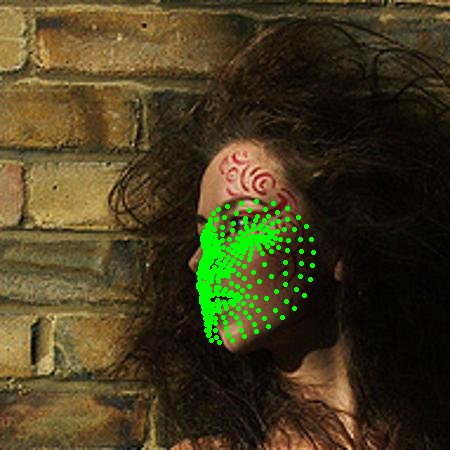

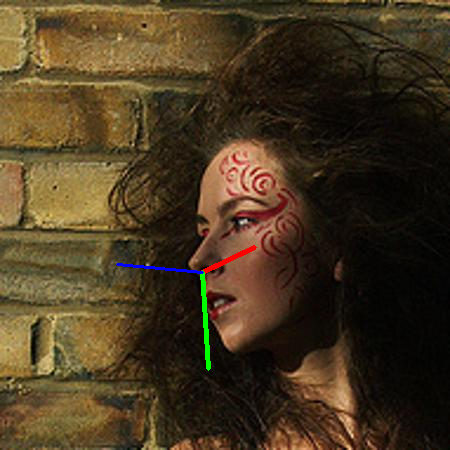

In [12]:
index = 100
img = cv2.imread('/content/drive/MyDrive/AFLW2000/' + image_names[index])
img_copy = img.copy()

for relative_x, relative_y in zip(X_points[index], y_points[index]):
  cv2.circle(img_copy, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)

cv2_imshow(img_copy)

cv2_imshow(draw_axis(img, labels[index][0], labels[index][1], labels[index][2], X_points[:, 1][index], y_points[:, 1][index]))

In [13]:
print('X points range from {} to {}'.format(X_points.min(), X_points.max()))
print('y points range from {} to {}'.format(y_points.min(), y_points.max()))
print('Labels range from {:.2f} to {:.2f}'.format(labels.min(), labels.max()))

X points range from 4 to 488
y points range from -26 to 429
Labels range from -16.97 to 15.60


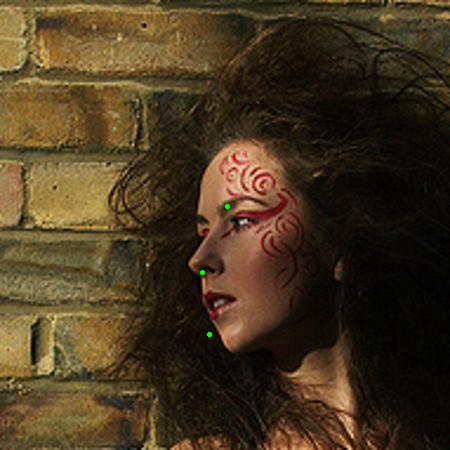

In [14]:
index = 100
img = cv2.imread('/content/drive/MyDrive/AFLW2000/' + image_names[index])
cv2.circle(img, (X_points[index, 1],y_points[index, 1]), radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(img, (X_points[index, 10],y_points[index, 10]), radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(img, (X_points[index, 171],y_points[index, 171]), radius=1, color=(0, 255, 0), thickness=2)
cv2_imshow(img)

In [15]:
Nose_centered_X = X_points - X_points[:,1].reshape(-1,1)
Nose_centered_y = y_points - y_points[:,1].reshape(-1,1)

X_171 = X_points[:,171]
X_10 = X_points[:,10]
y_171 = y_points[:,171]
y_10 = y_points[:,10]

distance = np.linalg.norm(np.array((X_10,y_10)) - np.array((X_171, y_171)),axis = 0).reshape(-1,1)
Norm_X = Nose_centered_X / distance
Norm_Y = Nose_centered_y / distance

print(Norm_X.shape)
print(Norm_Y.shape)

features = np.hstack([Norm_X,Norm_Y])
print(features.shape)

(1858, 468)
(1858, 468)
(1858, 936)


In [16]:
print("Features Min. Value:", features.min())
print("Features Max. Value:", features.max())

Features Min. Value: -1.0061048346297883
Features Max. Value: 1.05004714400665


In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, test_size=0.15, shuffle=True)

In [18]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
  train_predictions = model.predict(X_train)
  predictions = model.predict(X_test)
  train_MSE = mean_squared_error(y_train, train_predictions)
  test_MSE = mean_squared_error(y_test, predictions)
  print('Train MSE:', train_MSE)
  print('Train RMSE:', np.sqrt(train_MSE))
  print("Test MSE:", test_MSE)
  print("Test RMSE:", np.sqrt(test_MSE))

In [19]:
# fitting & evaluating a SVR model
SVR_model = MultiOutputRegressor(SVR())
SVR_model.fit(X_train, y_train)
evaluate_model(SVR_model, X_train, y_train, X_test, y_test)

Train MSE: 0.21836377352001912
Train RMSE: 0.4672940974589976
Test MSE: 0.037835295930897545
Test RMSE: 0.1945129711122051


In [20]:
# fitting & evaluating a RandomForestRegressor
RFC_model = RandomForestRegressor()
RFC_model.fit(X_train, y_train)
evaluate_model(RFC_model, X_train, y_train, X_test, y_test)

Train MSE: 0.03642608811157066
Train RMSE: 0.19085619746702137
Test MSE: 0.1206733431960569
Test RMSE: 0.34738068915248715


In [21]:
# fitting & evaluating a AdaBoostRegresor
AdaR = MultiOutputRegressor(AdaBoostRegressor())
AdaR.fit(X_train, y_train)
evaluate_model(AdaR, X_train, y_train, X_test, y_test)

Train MSE: 0.04400423749913187
Train RMSE: 0.209771870133085
Test MSE: 0.36807061940658437
Test RMSE: 0.6066882390541162


In [22]:
# fitting & evaluating a GradientBoostingRegressor
GBR = MultiOutputRegressor(GradientBoostingRegressor())
GBR.fit(X_train, y_train)
evaluate_model(GBR, X_train, y_train, X_test, y_test)

Train MSE: 0.0064983364601397834
Train RMSE: 0.08061225998655405
Test MSE: 0.32044750939049943
Test RMSE: 0.5660808329121376


In [23]:
label_names = ['pitch', 'yaw', 'roll']
svr_list = SVR_model.estimators_
for i, model in enumerate(svr_list):
  print(f'{label_names[i]} Model Eval')
  evaluate_model(model, X_train, y_train[:, i], X_test, y_test[:, i])
  print('\n')

pitch Model Eval
Train MSE: 0.2747618558309196
Train RMSE: 0.5241773133500911
Test MSE: 0.05807514069814454
Test RMSE: 0.24098784346548383


yaw Model Eval
Train MSE: 0.04833087219564291
Train RMSE: 0.2198428352156215
Test MSE: 0.008196614220030377
Test RMSE: 0.09053515460875061


roll Model Eval
Train MSE: 0.3319985925334945
Train RMSE: 0.5761931902873328
Test MSE: 0.047234132874517755
Test RMSE: 0.21733415027215064




In [24]:
def svr_grid_search(X_train, y_train, params):
    svr = SVR()
    grid_search = GridSearchCV(estimator=svr, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print('Best parameters:', best_params)
    return best_model

In [25]:
# performing grid-search for the pitch model
params = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}

pitch_model = svr_grid_search(X_train, y_train[:, 0], params)
evaluate_model(pitch_model, X_train, y_train[:, 0], X_test, y_test[:, 0])

Best parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Train MSE: 0.26896518558496535
Train RMSE: 0.5186185357128738
Test MSE: 0.058101896387787726
Test RMSE: 0.24104334960290386


In [26]:
# performing grid-search for the yaw model
params = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}

yaw_model = svr_grid_search(X_train, y_train[:, 1], params)
evaluate_model(yaw_model, X_train, y_train[:, 1], X_test, y_test[:, 1])

Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Train MSE: 0.04847433665607888
Train RMSE: 0.2201688821247882
Test MSE: 0.008613986485187568
Test RMSE: 0.09281156439360112


In [27]:
# performing grid-search for the roll model
params = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}

roll_model = svr_grid_search(X_train, y_train[:, 2], params)
evaluate_model(roll_model, X_train, y_train[:, 2], X_test, y_test[:, 2])

Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Train MSE: 0.2731256407907784
Train RMSE: 0.5226142370724112
Test MSE: 0.051985448331789814
Test RMSE: 0.22800317614408316


In [28]:
# saving the model as a pikcle file
with open('pitch_model.pkl', 'wb') as f:
    pickle.dump(pitch_model, f)

with open('yaw_model.pkl', 'wb') as f:
    pickle.dump(yaw_model, f)

with open('roll_model.pkl', 'wb') as f:
    pickle.dump(roll_model, f)

In [29]:
def detect_landmarks(img):
  face_module = mp.solutions.face_mesh
  X = []
  y = []
  with face_module.FaceMesh(static_image_mode=True) as face_mesh:
      results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks:
          for face_landmarks in results.multi_face_landmarks:
              shape = img.shape
              for landmark in face_landmarks.landmark:
                  relative_x = int(landmark.x * shape[1])
                  relative_y = int(landmark.y * shape[0])
                  X.append(relative_x)
                  y.append(relative_y)

  X = np.array([X])
  y = np.array([y])

  Nose_centered_X = X - X[:,1].reshape(-1,1)
  Nose_centered_y = y - y[:,1].reshape(-1,1)

  X_171 = X[:,171]
  X_10 = X[:,10]
  y_171 = y[:,171]
  y_10 = y[:,10]
  distance = np.linalg.norm(np.array((X_10,y_10)) - np.array((X_171, y_171)),axis = 0).reshape(-1,1)
  Norm_X = Nose_centered_X / distance
  Norm_Y = Nose_centered_y / distance

  nose_x = X[:,1]
  nose_y = y[:,1]

  features = np.hstack([Norm_X,Norm_Y])

  return features, nose_x, nose_y

In [30]:
def model_predict(pitch_model, yaw_model, roll_model, features):
  pitch = pitch_model.predict(features)
  yaw = yaw_model.predict(features)
  roll = roll_model.predict(features)
  return pitch, yaw, roll

In [31]:
def perform_prediction(pitch_model, yaw_model, roll_model, img):
  features, nose_x, nose_y = detect_landmarks(img)
  pitch, yaw, roll = model_predict(pitch_model, yaw_model, roll_model, features)
  frame = draw_axis(img, pitch, yaw, roll, nose_x, nose_y)
  return frame

<ipython-input-11-5601cb2feeb7>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-11-5601cb2feeb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:16: DeprecationWarning: Conve

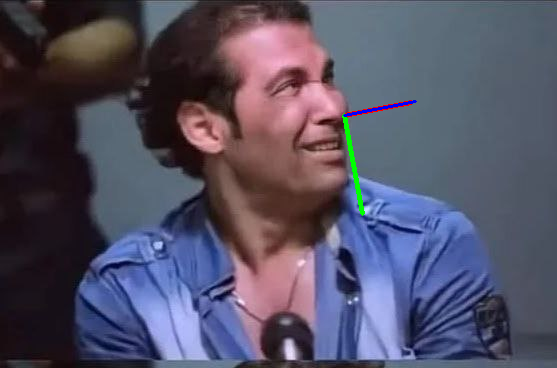

<ipython-input-11-5601cb2feeb7>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-11-5601cb2feeb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:16: DeprecationWarning: Conve

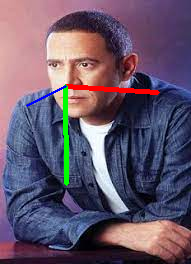

<ipython-input-11-5601cb2feeb7>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-11-5601cb2feeb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:16: DeprecationWarning: Conve

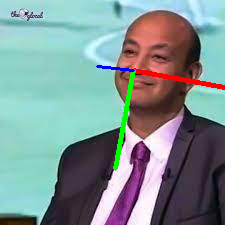

<ipython-input-11-5601cb2feeb7>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-11-5601cb2feeb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:16: DeprecationWarning: Conve

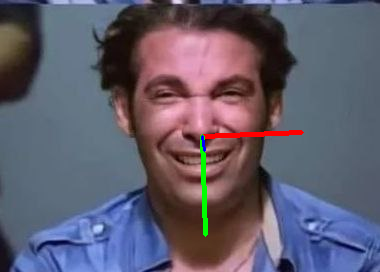

<ipython-input-11-5601cb2feeb7>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-11-5601cb2feeb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:16: DeprecationWarning: Conve

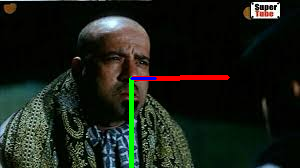

<ipython-input-11-5601cb2feeb7>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-11-5601cb2feeb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:16: DeprecationWarning: Conve

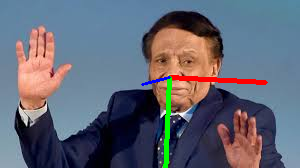

<ipython-input-11-5601cb2feeb7>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-11-5601cb2feeb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-11-5601cb2feeb7>:16: DeprecationWarning: Conve

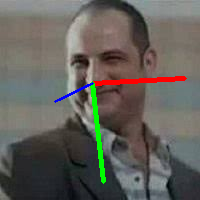

In [32]:
test_images = '/content/test_images/'
for image_name in os.listdir(test_images):
  img = cv2.imread(test_images + image_name)
  cv2_imshow(perform_prediction(pitch_model, yaw_model, roll_model, img))

In [ ]:
cap = cv2.VideoCapture('/content/video_2024-03-06_21-46-02.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/output.mp4', fourcc, frame_rate, (width, height))
while True:
        try:
            ret, frame = cap.read()
            if not ret:
              break
            frame = perform_prediction(pitch_model, yaw_model, roll_model, frame)

            out.write(frame)
        except:
          pass

cap.release()
out.release()

Streaming output truncated to the last 5000 lines.
<ipython-input-10-d7713a74df4f>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-10-d7713a74df4f>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy
<ipython-input-10-d7713a74df4f>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x3 = size * (sin(yaw)) + tdx
<ipython-input-10-d771